<h1><center>xView2</center></h1>
<h3><center> “The xView2 Challenge focuses on automating the process of assessing building damage after a natural disaster, an analytical bottleneck in the post-disaster workflow. “ - DIU </center></h3>
<center> <a>https://www.ibm.com/blog/the-xview2-ai-challenge/</a></center> 
<div>
    <center>
<img src="pictures/DIU.png" width="600"/>
        <center>
</div>




<h1><center>xBD</center></h1>
<h3><center>A large-scale dataset for the advancement of change detection and building damage assessment for humanitarian assistance and disaster recovery research. </center></h3>

<table>
    <row>
        <td>
            <h1><center>Pre-disaster Image</center></h1>
  <div>
    <center>
<img src="pictures/pre.png" width="400"/>
        <center>
</div>
            </td>
            <td>
<h1><center>Post-disaster Image</center></h1>
<div>
    <center>
<img src="pictures/post.png" width="400"/>
        <center>
</div>  
            </td>
    </row>
</table>
<h1><center>Label</center></h1>
<div>
    <center>
<img src="pictures/label.png" width="600"/>
        <center>
</div>


<table>
<row>
<td>
<center>
<img src="pictures/AreaPerDisaster.png" width="500"/>
<center>
</td>
<td>
<center>
<img src="pictures/polygon_overlay.png" width="500"/>
<center>
</td>
</row>
</table>
<table>
<row>
<td>
<center>
<img src="pictures/DamageLabel.png" width="500"/>
<center>
</td>
<td>
    <center>
<img src="pictures/PolygonPerDisaster.png" width="500"/>
        <center>
</td>
</row>
</table>

<h1>Agenda</h1>
<h2>1. Segmentation </h2> To find the buildings on the satellite image. 
<h2>2. Classification </h2> To classify the buildings into damage levels.

<h1><center>Segmentation</center></h1>

<div>
    <center>
<img src="pictures/segmentation.png" width="600"/>
        <center>
</div> 

  <center><h4>For prediction, we train a UNET-based algorithm with satellite images and their masks.  </h4> </center>

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from skimage.io import imread, imshow
from shapely import wkt
import geopandas
from osgeo import gdal
from osgeo import ogr
import cv2
import tensorflow as tf
import random
from skimage.transform import resize
import matplotlib.pyplot as plt
from osgeo import osr
from PIL import Image as img
from IPython.display import JSON
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from urllib.request import urlopen
import tarfile
from io import BytesIO

2023-08-01 14:28:38.490736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 14:28:38.616984: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-01 14:28:38.655928: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-01 14:28:39.357050: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# download train data
r = urlopen("https://files.bwsi-remote-sensing.net/data/xview/train_images_labels_targets.tar")
t = tarfile.open(name=None, fileobj=BytesIO(r.read()))
t.extractall("../")
t.close()

# download test data
r = urlopen("https://files.bwsi-remote-sensing.net/data/xview/test_images_labels_targets.tar")
t = tarfile.open(name=None, fileobj=BytesIO(r.read()))
t.extractall("../")
t.close()

# create needed folders
folders = ['json','masks','model']
for folder in folders:
    os.makedirs(folder)

### Agenda - Segmentation

1. Data
2. Building footprint
3. Masks
4. Data Augmentation
5. Model
6. Validation

### 1. Data

In [3]:
train_data_dir = r'../train/images/'
labels_data_dir = r'../train/labels/' 
train_data = [file for file in os.listdir(train_data_dir) if 'pre' in file]
labels_data = [file for file in os.listdir(labels_data_dir)[0:len(os.listdir(labels_data_dir))] if 'pre' in file]
train_data_df = pd.DataFrame({'Train_Data':train_data})
labels_data_df = pd.DataFrame({'Label_Data':labels_data})

In [4]:
test_data_dir = r'../test/images/'
test_labels_data_dir = r'../test/labels/' 
test_data = [file for file in os.listdir(test_data_dir) if 'pre' in file]
test_labels_data = [file for file in os.listdir(test_labels_data_dir)[0:len(os.listdir(test_labels_data_dir))] if 'pre' in file]
test_data_df = pd.DataFrame({'Test_Data':test_data})
test_labels_data_df = pd.DataFrame({'Test_Label_Data':labels_data})

#### Images

In [5]:
train_data_df.head()

,Train_Data
0,hurricane-florence_00000477_pre_disaster.png
1,socal-fire_00000772_pre_disaster.png
2,hurricane-harvey_00000045_pre_disaster.png
3,santa-rosa-wildfire_00000297_pre_disaster.png
4,hurricane-michael_00000523_pre_disaster.png


In [6]:
# disaster events and counts
events = [x.split('_')[0] for x in train_data_df.Train_Data]
for event in set(events):
    print(f'{event} = {events.count(event)}')

hurricane-florence = 319
hurricane-michael = 343
santa-rosa-wildfire = 226
mexico-earthquake = 121
hurricane-harvey = 319
hurricane-matthew = 238
guatemala-volcano = 18
palu-tsunami = 113
midwest-flooding = 279
socal-fire = 823


#### disaster types 

1. volcano, 
2. hurricane, 
3. earthquake, 
4. flooding,
5. tsunami,
6. wildfire,
7. fire.

In [7]:
train_data_df.count()

Train_Data    2799
dtype: int64

../train/images/hurricane-florence_00000477_pre_disaster.png


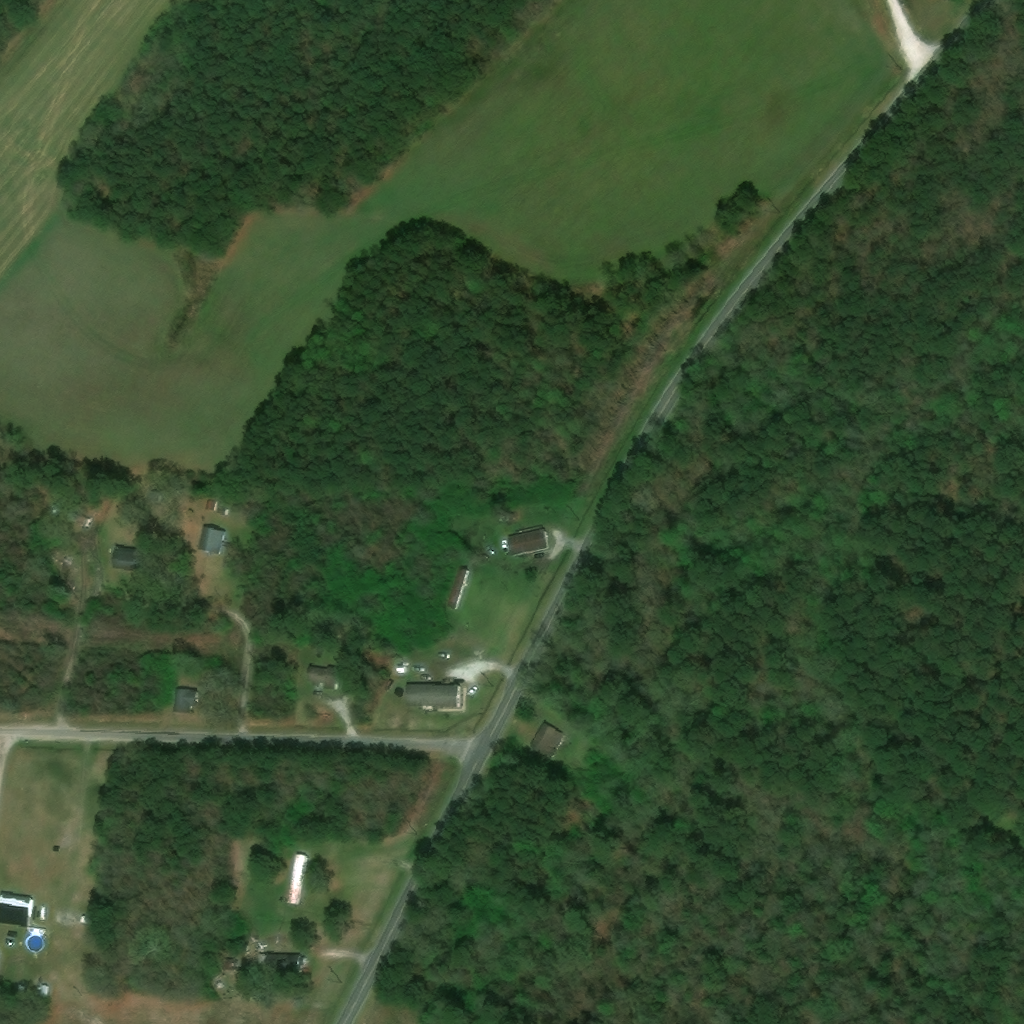

In [8]:
image_filename = os.path.join(train_data_dir, train_data[0].title().lower())
img = Image(filename=image_filename)
img.height= 300
img.width = 300
print(image_filename)
display(img)

#### Labels

In [9]:
labels_data_df.head()

,Label_Data
0,santa-rosa-wildfire_00000276_pre_disaster.json
1,socal-fire_00000118_pre_disaster.json
2,socal-fire_00000810_pre_disaster.json
3,hurricane-matthew_00000102_pre_disaster.json
4,socal-fire_00001390_pre_disaster.json


In [10]:
# To visualize the content of JSON file
with open(os.path.join(labels_data_dir, 'midwest-flooding_00000108_pre_disaster.json'), 'r') as f:
                data = json.load(f)
                json_formatted_str = json.dumps(data, indent=2)
                print(json_formatted_str)

{
  "features": {
    "lng_lat": [
      {
        "properties": {
          "feature_type": "building",
          "uid": "e00bc2ea-b2af-4093-8685-048d0066b480"
        },
        "wkt": "POLYGON ((-96.2124999551873 36.35194821297325, -96.21253022979653 36.35203504855623, -96.21252561741356 36.35211978417846, -96.21227522379515 36.35214479046068, -96.21225450900431 36.35196819270638, -96.2124999551873 36.35194821297325))"
      },
      {
        "properties": {
          "feature_type": "building",
          "uid": "cf7faa40-6311-4fc6-81fb-b77b7d863321"
        },
        "wkt": "POLYGON ((-96.2121359497383 36.35189727309382, -96.21195345710693 36.35190130909216, -96.21195023695203 36.35194364132299, -96.211964218681 36.35196701531144, -96.21214327883925 36.35196336010638, -96.21214327407627 36.351931554427, -96.2121359497383 36.35189727309382))"
      },
      {
        "properties": {
          "feature_type": "building",
          "uid": "e857d253-560a-414c-a6b4-aba5ef148828"
     

### 2. Building footprint

We need building footprints to create masks for training our algorithm

In [11]:
# function to create building footprint geometry from geojson files
def building_footprint_from_json(data,labels_data_dir=labels_data_dir):
    xy_geom = []
    file_name = []
    for j in range(len(data)):
        filename = data[j].title()
        df = pd.read_json(os.path.join(labels_data_dir, filename.lower()))
        for i in range(len(df.loc['lng_lat'][0])):
            if 'wkt' in df.loc['xy'][0][i]:
                xy_geom.append(df.loc['xy'][0][i]['wkt'])
            else:
                building_geom.append('')
            file_name.append(filename)
    return pd.DataFrame({'xy':xy_geom,'filename':file_name})

In [12]:
# create a dataframe to hold the building footprint
building_footprint = building_footprint_from_json(labels_data)

In [13]:
building_footprint.head() 

,xy,filename
0,"POLYGON ((3.893687950299892 42.0383796018368, ...",Santa-Rosa-Wildfire_00000276_Pre_Disaster.Json
1,"POLYGON ((437.4001962235625 0, 367.51383104473...",Santa-Rosa-Wildfire_00000276_Pre_Disaster.Json
2,"POLYGON ((558.6211460988145 78.34499727373507,...",Santa-Rosa-Wildfire_00000276_Pre_Disaster.Json
3,"POLYGON ((582.8703445227094 170.7363397300223,...",Santa-Rosa-Wildfire_00000276_Pre_Disaster.Json
4,"POLYGON ((458.3482508033833 204.9845209979643,...",Santa-Rosa-Wildfire_00000276_Pre_Disaster.Json


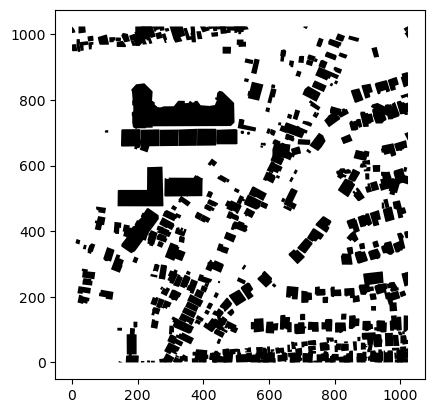

In [14]:
# create geopandas dataframe from building footprint for train data
geo_df = building_footprint.copy()
geo_df['xy'] = geo_df['xy'].apply(wkt.loads)
geo_df = geopandas.GeoDataFrame(geo_df, geometry='xy')
geo_df[geo_df['filename'].str.contains("00000108")].plot(color='black')
plt.show()

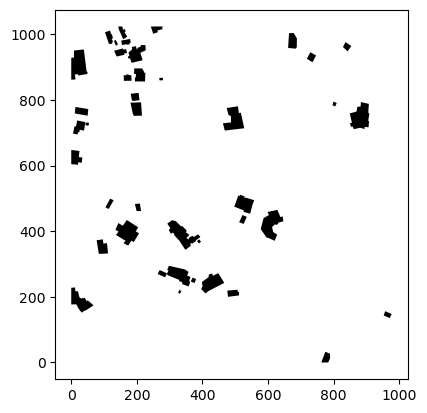

In [15]:
# create geopandas dataframe from building footprint for test data
test_building_footprint = building_footprint_from_json(test_labels_data,test_labels_data_dir)
test_geo_df = test_building_footprint.copy()
test_geo_df['xy'] = test_geo_df['xy'].apply(wkt.loads)
test_geo_df = geopandas.GeoDataFrame(test_geo_df, geometry='xy')
test_geo_df[test_geo_df['filename'].str.contains("00001074")].plot(color='black')
plt.show()

In [16]:
test_geo_df.head()

,xy,filename
0,"POLYGON ((27.143 69.218, 2.758 75.605, 1.829 7...",Hurricane-Harvey_00000415_Pre_Disaster.Json
1,"POLYGON ((53.465 46.627, 56.346 54.118, 55.482...",Hurricane-Harvey_00000415_Pre_Disaster.Json
2,"POLYGON ((0.000 182.522, 6.961 180.867, 7.696 ...",Hurricane-Harvey_00000415_Pre_Disaster.Json
3,"POLYGON ((14.442 174.643, 16.338 184.912, 23.5...",Hurricane-Harvey_00000415_Pre_Disaster.Json
4,"POLYGON ((71.155 154.639, 80.348 150.043, 85.3...",Hurricane-Harvey_00000415_Pre_Disaster.Json


### 3. Masks

In [17]:
def create_poly_mask(rasterSrc, vectorSrc, npDistFileName='', 
                            noDataValue=0, burn_values=1):
    
    from PIL import ImageFile, Image as img   
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    
    ## open source vector file that truth data
    source_ds = ogr.Open(vectorSrc)
    source_layer = source_ds.GetLayer()

    ## extract data from src Raster File to be emulated
    ## open raster file that is to be emulated
    srcRas_ds = gdal.Open(rasterSrc)
    cols = srcRas_ds.RasterXSize
    rows = srcRas_ds.RasterYSize

    if npDistFileName == '':
        dstPath = ".tmp.tiff"
    else:
        dstPath = npDistFileName

    ## create First raster memory layer, units are pixels
    # Change output to geotiff instead of memory 
    memdrv = gdal.GetDriverByName('GTiff') 
    dst_ds = memdrv.Create(dstPath, cols, rows, 1, gdal.GDT_Byte, 
                           options=['COMPRESS=LZW'])
    dst_ds.SetGeoTransform(srcRas_ds.GetGeoTransform())
    dst_ds.SetProjection(srcRas_ds.GetProjection())
    band = dst_ds.GetRasterBand(1)
    band.SetNoDataValue(noDataValue)    
    gdal.RasterizeLayer(dst_ds, [1], source_layer, burn_values=[burn_values])
    dst_ds = 0

    mask_image = img.open(dstPath)
    mask_image = np.array(mask_image)
    return mask_image,np.array(img.open(rasterSrc))

In [18]:
def image_mask_pair(row,geo_df,raster_source_folder,json_dest_folder,mask_dest_folder):
    filename = row.title()
    row_df = geo_df[geo_df['filename'].str.contains(filename.split('.')[0])]
    json_file = json_dest_folder+filename.split('.')[0] +".json"
    if len(row_df)!=0:
        row_df.to_file(json_file, driver="GeoJSON")
        raster_file = raster_source_folder + filename.lower()
        mask_file = mask_dest_folder + filename + '.tif'
        label, image = create_poly_mask(raster_file, json_file, npDistFileName=mask_file, 
                                    noDataValue=0, burn_values=255)
        return label, image
    else:
        return None, None
    

In [19]:
# create masks - train
json_dest_folder = "./json/"
mask_dest_folder = './masks/'

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

N = 400 #len(train_data)

x_train = np.zeros((N, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
y_train = np.zeros((N, IMG_HEIGHT, IMG_WIDTH))

for i in range(N):
    label, image = image_mask_pair(train_data[i],geo_df,train_data_dir,json_dest_folder,mask_dest_folder)
    if (image is not None) & (label is not None):
        x_train[i] = resize(image, (IMG_HEIGHT, IMG_WIDTH))
        y_train[i] = resize(label, (IMG_HEIGHT, IMG_WIDTH))

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [20]:
# create masks - test
json_dest_folder = "./json/"
mask_dest_folder = './masks/'

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

N = 30 #len(test_data)

x_test = np.zeros((N, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
y_test = np.zeros((N, IMG_HEIGHT, IMG_WIDTH))

for i in range(N):
    label, image = image_mask_pair(test_data[i],test_geo_df,test_data_dir,json_dest_folder,mask_dest_folder)
    if (image is not None) & (label is not None):
        x_test[i] = resize(image, (IMG_HEIGHT, IMG_WIDTH))
        y_test[i] = resize(label, (IMG_HEIGHT, IMG_WIDTH))

In [21]:
len(x_train),len(x_test)

(400, 30)

In [22]:
len(x_train),len(x_test)

(400, 30)

### 4. Data Augmentation

In [23]:
def image_mask_generator(image_data_generator, mask_data_generator):
    gen = zip(image_data_generator, mask_data_generator)
    for (img, mask) in gen:
        yield (img, mask)

In [24]:
# Train data

SEED = 100

train_image_data_generator = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 10,
    zoom_range = 0.1
).flow(x_train, batch_size = 16, seed = SEED)

train_mask_data_generator = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 10,
    zoom_range = 0.1
).flow(y_train.reshape(len(y_train),128,128,1), batch_size = 16, seed = SEED)

In [25]:
# Test data

SEED = 100

test_image_data_generator = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 10,
    zoom_range = 0.1
).flow(x_test, batch_size = 16, seed = SEED)

test_mask_data_generator = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 10,
    zoom_range = 0.1
).flow(y_test.reshape(len(y_test),128,128,1), batch_size = 16, seed = SEED)

In [26]:
train_generator = image_mask_generator(train_image_data_generator, train_mask_data_generator)
test_generator = image_mask_generator(test_image_data_generator, test_mask_data_generator)

### 5. Model

In [27]:
Image(url="pictures/unet.jpeg", width=900, height=900)

In [28]:
# unet model
def get_UNET(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    # Build U-Net model
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(c5)

    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [29]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

model = get_UNET(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

2023-08-01 15:00:20.120824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-01 15:00:20.269822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-01 15:00:20.270118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-01 15:00:20.272927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [30]:
model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

### Let's start with a smaller sample set

In [31]:
result = model.fit(train_generator,steps_per_epoch= len(x_train)/ 32, epochs=100)

Epoch 1/100


2023-08-01 15:09:26.071053: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


12/12 [==============================] - 9s 78ms/step - loss: 0.6343 - accuracy: 0.5948
Epoch 2/100
12/12 [==============================] - 1s 79ms/step - loss: 0.3736 - accuracy: 0.8284
Epoch 3/100
12/12 [==============================] - 1s 80ms/step - loss: 0.2717 - accuracy: 0.8496
Epoch 4/100
12/12 [==============================] - 1s 79ms/step - loss: 0.2338 - accuracy: 0.8436
Epoch 5/100
12/12 [==============================] - 1s 81ms/step - loss: 0.2037 - accuracy: 0.8512
Epoch 6/100
12/12 [==============================] - 1s 81ms/step - loss: 0.1991 - accuracy: 0.8471
Epoch 7/100
12/12 [==============================] - 1s 80ms/step - loss: 0.1921 - accuracy: 0.8451
Epoch 8/100
12/12 [==============================] - 1s 80ms/step - loss: 0.1683 - accuracy: 0.8610
Epoch 9/100
12/12 [==============================] - 1s 80ms/step - loss: 0.1745 - accuracy: 0.8559
Epoch 10/100
12/12 [==============================] - 1s 81ms/step - loss: 0.1899 - accuracy: 0.8362
Epoch 11/10

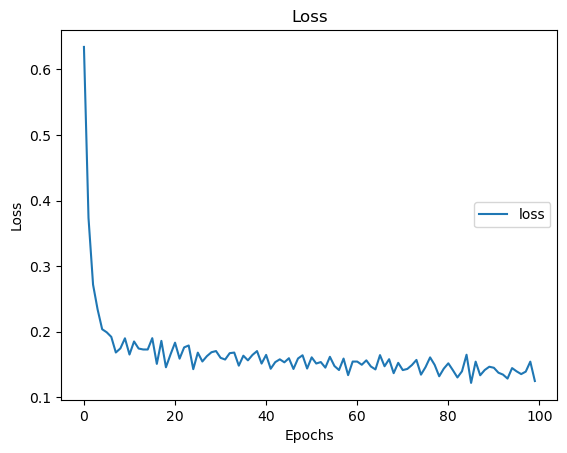

In [32]:
# loss curve
plt.title('Loss')
plt.plot(result.history['loss'], label='loss')
plt.legend(loc='center right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='center right');

In [33]:
# Evaluate the restored model
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print('model accuracy: {:5.2f}%'.format(100 * acc))

1/1 - 1s - loss: 0.4004 - accuracy: 0.8671 - 852ms/epoch - 852ms/step
model accuracy: 86.71%


28
1/1 [==============================] - 0s 27ms/step


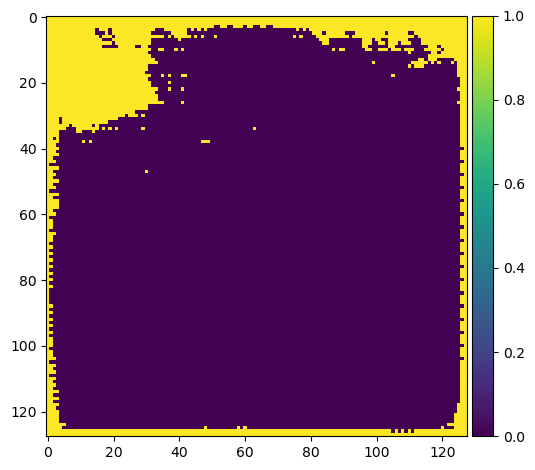

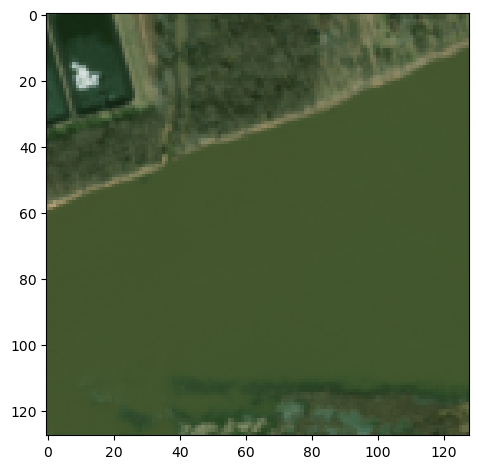

In [55]:
# What pixels are classified as buildings?
idx = 28
print(idx)
x=np.array(x_test[idx])
x=np.expand_dims(x,axis=0)
pred = model.predict(x, verbose=1)
pred = (pred>0.0001).astype(np.uint8)
imshow(np.squeeze(pred[0]));
plt.show()
imshow(x_test[idx]);

### Now, let's consider the whole dataset

In [25]:
result = model.fit(train_generator,steps_per_epoch= len(x_train)/ 32, epochs=100)

Epoch 1/100


2023-07-17 22:04:20.694494: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2023-07-17 22:04:21.187838: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30408704 exceeds 10% of free system memory.
2023-07-17 22:04:21.246090: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 28311552 exceeds 10% of free system memory.
2023-07-17 22:04:21.515881: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.
2023-07-17 22:04:21.516344: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.


87/87 [==============================] - 540s 6s/step - loss: 0.2635 - accuracy: 0.8215
Epoch 2/100
87/87 [==============================] - 525s 6s/step - loss: 0.1853 - accuracy: 0.8369
Epoch 3/100
87/87 [==============================] - 524s 6s/step - loss: 0.1858 - accuracy: 0.8327
Epoch 4/100
87/87 [==============================] - 523s 6s/step - loss: 0.1743 - accuracy: 0.8401
Epoch 5/100
87/87 [==============================] - 527s 6s/step - loss: 0.1694 - accuracy: 0.8387
Epoch 6/100
87/87 [==============================] - 517s 6s/step - loss: 0.1664 - accuracy: 0.8389
Epoch 7/100
87/87 [==============================] - 519s 6s/step - loss: 0.1586 - accuracy: 0.8424
Epoch 8/100
87/87 [==============================] - 523s 6s/step - loss: 0.1708 - accuracy: 0.8301
Epoch 9/100
87/87 [==============================] - 526s 6s/step - loss: 0.1629 - accuracy: 0.8313
Epoch 10/100
87/87 [==============================] - 529s 6s/step - loss: 0.1550 - accuracy: 0.8417
Epoch 11/10

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [27]:
# Save model
#!mkdir -p model2
model.save('model/segmentation')

INFO:tensorflow:Assets written to: model2/my_model/assets


INFO:tensorflow:Assets written to: model2/my_model/assets


In [29]:
# Load model
new_model = tf.keras.models.load_model('model/segmentation')

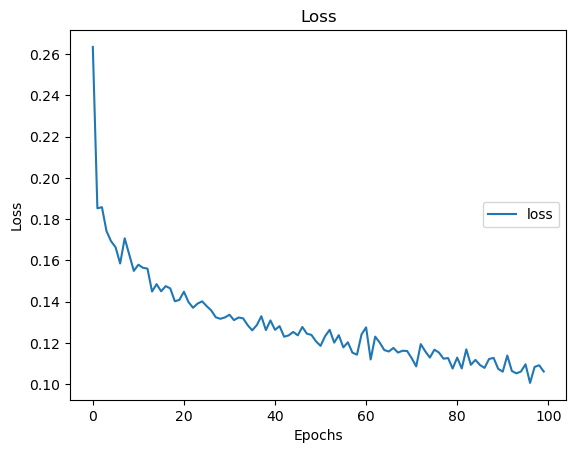

In [28]:
# loss curve
plt.title('Loss')
plt.plot(result.history['loss'], label='loss')
plt.legend(loc='center right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='center right');

In [30]:
# Evaluate the restored model
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print('model accuracy: {:5.2f}%'.format(100 * acc))

30/30 - 75s - loss: 0.1126 - accuracy: 0.8584 - 75s/epoch - 3s/step
model accuracy: 85.84%


8
1/1 [==============================] - 0s 202ms/step


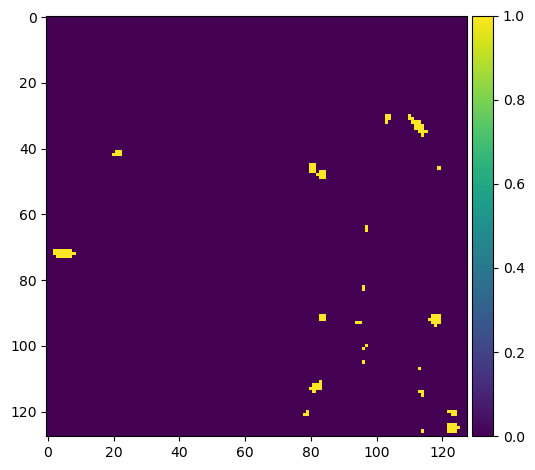

In [34]:
idx = 8
print(idx)
x=np.array(x_test[idx])
x=np.expand_dims(x,axis=0)
pred = model.predict(x, verbose=1)
pred = (pred>0.5).astype(np.uint8)
imshow(np.squeeze(pred[0]));

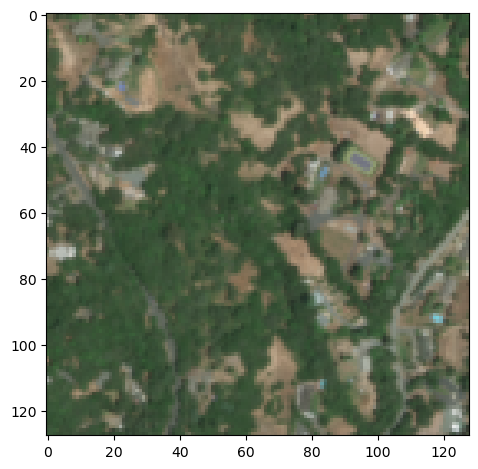

In [35]:
imshow(x_test[idx]);

### Exercise

Again, we should try to vary the model's parameters such as learning rates, loss function and epochs to see how the model's performance changes.